<a href="https://colab.research.google.com/github/Fuhui-Chen/Fastbook-Practice/blob/master/02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **From Model to Production**

The State of Deep Learning（just for 2020）
1.Computer vision（object recognition）

2.Text (natural language processing)
-Very good at generating context-appropriate text, such as replies to social media posts, and imitating a particular author's style.
-Not good at generating correct responses.

3.Combining text and images
-Combine text and images into a single model.

4.Tabular data
-Deep learning does greatly increase the variety of columns that you can include, but generally take longer to train than random forests or gradient boosting machines.

5.Recommendation systems



Gathering Data
-To download images with Bing Image Search, sign up at Microsoft for a free account.[链接文字]azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/


In [0]:
pip install fastai2

     |████████████████████████████████| 194kB 2.7MB/s 


In [0]:
pip install utils

In [0]:
 pip install azure-cognitiveservices-search-imagesearch


In [0]:
from fastai2.vision.all import *


In [0]:
from fastai2.vision.widgets import *

In [0]:

from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api
from msrest.authentication import CognitiveServicesCredentials as auth




In [0]:

def search_images_bing(key, term, min_sz=128):
    client = api('https://api.cognitive.microsoft.com', auth(key))
    return L(client.images.search(query=term, count=150, min_height=min_sz, min_width=min_sz).value)

In [0]:
from utils import *

In [0]:
key = 'af334b39ff6f470086f7cfd3d159d562'

In [0]:

search_images_bing

<function __main__.search_images_bing>

In [0]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [0]:

#hide
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [0]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [0]:

if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [0]:

fns = get_image_files(path)
fns

(#440) [Path('bears/teddy/00000147.jpg'),Path('bears/teddy/00000061.jpg'),Path('bears/teddy/00000081.jpg'),Path('bears/teddy/00000079.jpg'),Path('bears/teddy/00000003.jpg'),Path('bears/teddy/00000100.jpg'),Path('bears/teddy/00000030.jpg'),Path('bears/teddy/00000044.jpg'),Path('bears/teddy/00000029.jpg'),Path('bears/teddy/00000060.jpg')...]

In [0]:
failed = verify_images(fns)
failed

(#20) [Path('bears/teddy/00000017.jpg'),Path('bears/teddy/00000140.jpg'),Path('bears/teddy/00000062.jpg'),Path('bears/teddy/00000018.jpg'),Path('bears/teddy/00000145.jpg'),Path('bears/teddy/00000074.jpg'),Path('bears/teddy/00000143.jpg'),Path('bears/teddy/00000098.jpg'),Path('bears/teddy/00000111.jpg'),Path('bears/teddy/00000129.jpg')...]

In [0]:

failed.map(Path.unlink);

In [0]:
pip install DataLoader

  Created wheel for DataLoader: filename=dataloader-2.0-cp36-none-any.whl size=10100 sha256=4eed48ff0d531d62ce8d9d24deeac483f3ceab7cd0a62c67a3bc76c0b515704c
  Stored in directory: /root/.cache/pip/wheels/3a/a0/74/7190a79f983c5276ddcfe888612746a633d8ed0c0eaf7fa42d
Successfully built DataLoader


In [0]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [0]:

dls = bears.dataloaders(path)

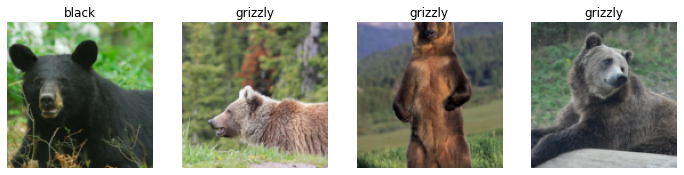

In [0]:
dls.valid.show_batch(max_n=4, nrows=1)

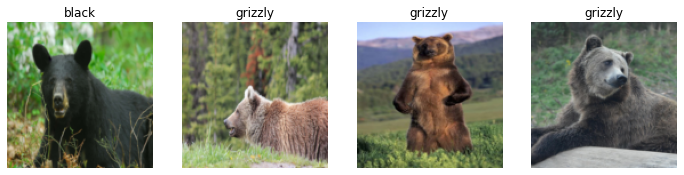

In [0]:

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

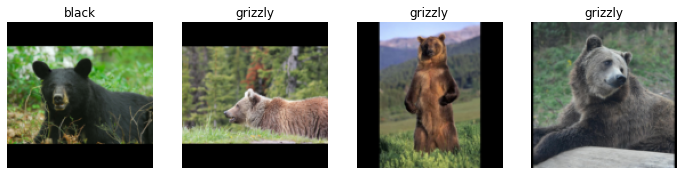

In [0]:

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

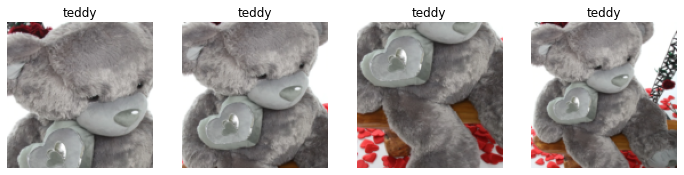

In [0]:

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

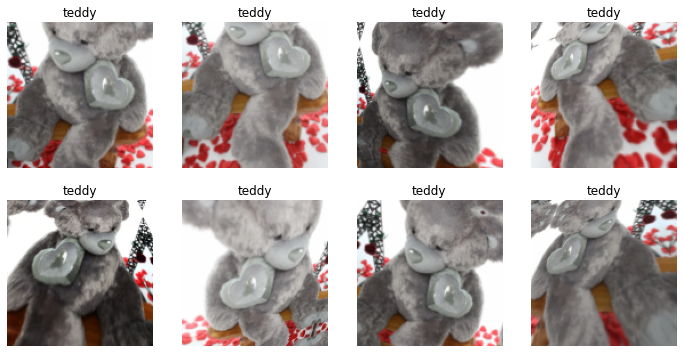

In [0]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [0]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [0]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.494221,0.060411,0.023810,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.212273,0.024475,0.000000,01:47
1,0.183310,0.008021,0.000000,01:47
2,0.134628,0.005657,0.000000,01:47
3,0.111166,0.005476,0.000000,01:46


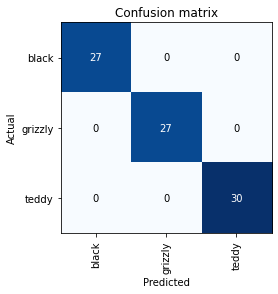

In [0]:

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

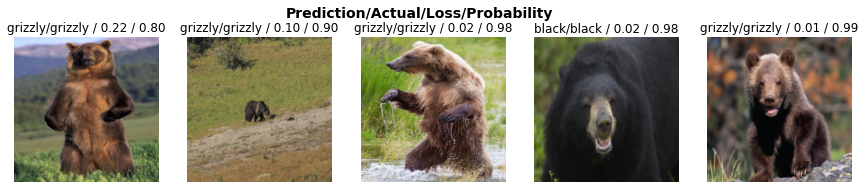

In [0]:
interp.plot_top_losses(5, nrows=1)

In [0]:

#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [0]:
learn.export()

In [0]:

path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [0]:

learn_inf = load_learner(path/'export.pkl')

In [0]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.5350e-04, 9.9984e-01, 9.0990e-06]))

In [0]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

In [0]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [0]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [0]:

img = PILImage.create(btn_upload.data[-1])

In [0]:

#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [0]:

pred,pred_idx,probs = learn_inf.predict(img)

In [0]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9998')

In [0]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [0]:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [0]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [0]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])